In [ ]:
%cd /content/drive/My Drive/project_folder/heatmapping

/content/drive/My Drive/project_folder/heatmapping


In [ ]:
import cv2
import numpy
image = cv2.imread('img_4956.jpg',0)
image = cv2.resize(image,(28,28))
image = cv2.bitwise_not(image)
img = image.reshape(1, 28, 28, 1)
img = img.astype('float32')
img = img / 255.0
imgarray = numpy.array(img)
imgarray = imgarray.flatten()
numpy.savetxt("data/X.txt", imgarray, fmt='%f', delimiter=" ")

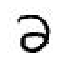

In [ ]:
import utils
X,T = utils.loaddata()
%matplotlib inline
utils.digit(X.reshape(1,1,28,28).transpose(0,2,1,3).reshape(28,28),9,0.75)

In [ ]:
W,B = utils.loadparams()
L = len(W)
print(L)

3


In [ ]:
import numpy
A = [X]+[None]*L
for l in range(L):
    A[l+1] = numpy.maximum(0,A[l].dot(W[l])+B[l])    

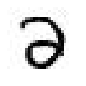

[0] 0.0
  [1] 26.5
  [2] 26.1
  [3] 1.0
  [4] 0.0
  [5] 0.0
  [6] 0.0
  [7] 30.6
  [8] 0.0
  [9] 0.0



In [ ]:
#for i in range(1):
utils.digit(X.reshape(28,28),1.0,1.0)
p = A[L]
print("  ".join(['[%1d] %.1f\n'%(d,p[d]) for d in range(10)]))


In [ ]:
R = [None]*L + [A[L]*(T==numpy.arange(10))]
print(R)

[None, None, None, array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , 30.57437435,  0.        ,  0.        ])]


In [ ]:
def rho(w,l):  return w + [None,0.1,0.0,0.0][l] * numpy.maximum(0,w)
def incr(z,l): return z + [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9 ()

In [ ]:
for l in range(1,L)[::-1]:

    w = rho(W[l],l)
    b = rho(B[l],l)
    
    z = incr(A[l].dot(w)+b,l)    
    s = R[l+1] / z               
    c = s.dot(w.T)               
    R[l] = A[l]*c  

TypeError: ignored

In [ ]:
w  = W[0]
wp = numpy.maximum(0,w)
wm = numpy.minimum(0,w)
lb = A[0]*0-1
hb = A[0]*0+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9        # step 1
s = R[1]/z                                        # step 2
c,cp,cm  = s.dot(w.T),s.dot(wp.T),s.dot(wm.T)     # step 3
R[0] = A[0]*c-lb*cp-hb*cm                         # step 4

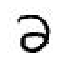

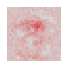

In [ ]:
utils.digit(X.reshape(1,1,28,28).transpose(0,2,1,3).reshape(28,28),9,0.75)
utils.heatmap(R[0].reshape(1,1,28,28).transpose(0,2,1,3).reshape(28,28),9,0.75)

In [ ]:
import cv2
import numpy
im = cv2.imread('castle.jpg')
im = cv2.resize(im,(224,224))
img = numpy.array(im)[...,::-1]/255.0

In [ ]:
import torch
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)
X = (torch.FloatTensor(img[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std

In [ ]:
import torchvision
import utils
model = torchvision.models.vgg16(pretrained=True); model.eval()
layers = list(model._modules['features']) + utils.toconv(list(model._modules['classifier']))
L = len(layers)
print("Layers"+str(L))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



Layers38


In [ ]:
A = [X]+[None]*L
for l in range(L): A[l+1] = layers[l].forward(A[l])

In [ ]:
scores = numpy.array(A[-1].data.view(-1))
ind = numpy.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(utils.imgclasses[i][:20],i,scores[i]))

              castle (483): 11.029
church, church build (497):  9.522
           monastery (663):  9.401
 bell cote, bell cot (442):  9.047
cinema, movie theate (498):  8.016
        analog clock (409):  7.108
         street sign (919):  7.102
traffic light, traff (920):  7.058
thatch, thatched roo (853):  6.978
                 alp (970):  6.812


In [ ]:
T = torch.FloatTensor((1.0*(numpy.arange(1000)==497).reshape([1,1000,1,1])))
R = [None]*L + [(A[-1]*T).data]

In [ ]:
for l in range(1,L)[::-1]:
    
    A[l] = (A[l].data).requires_grad_(True)

    if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):

        if l <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
        if 17 <= l <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        if l >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9

        z = incr(utils.newlayer(layers[l],rho).forward(A[l]))  # step 1
        s = (R[l+1]/z).data                                    # step 2
        (z*s).sum().backward(); c = A[l].grad                  # step 3
        R[l] = (A[l]*c).data                                   # step 4
        
    else:
        
        R[l] = R[l+1]

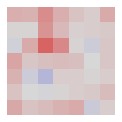

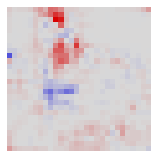

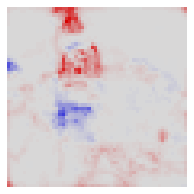

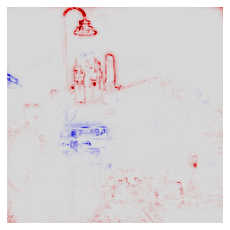

In [ ]:
for i,l in enumerate([31,21,11,1]):
    utils.heatmap(numpy.array(R[l][0]).sum(axis=0),0.5*i+1.5,0.5*i+1.5)

In [ ]:
A[0] = (A[0].data).requires_grad_(True)

lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)

z = layers[0].forward(A[0]) + 1e-9                                     # step 1 (a)
z -= utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
z -= utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
s = (R[1]/z).data                                                      # step 2
(z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
R[0] = (A[0]*c+lb*cp+hb*cm).data                                       # step 4

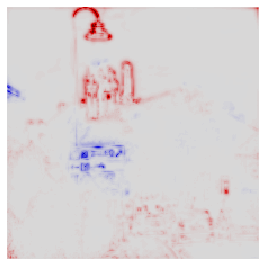

In [ ]:
otp=utils.heatmap(numpy.array(R[0][0]).sum(axis=0),3.5,3.5)